# EDA on churn dataset

In this notebook we will perform exploratory data analysis on the Telco Customer Churn dataset. We do this as final project fot the Exploratory Data Analysis for Machine Learning course by Coursera (www.coursera.org/learn/ibm-exploratory-data-analysis-for-machine-learning). We will provide insight into the different features present in the dataset and how they relate to customer churn. The final aim is to predict behavior to retain customers.

## Data summary

Let's begin by importing the libraries we will use throughout the notebook.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

We can now load the dataset, and start looking into it.

In [3]:
churn_df = pd.read_csv('churn_ds.csv')

print('Number of samples: {}'.format(len(churn_df)))
print('Features in dataset: {}'.format(churn_df.columns.to_list()))

Number of samples: 10000
Features in dataset: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


The 3 first features: RowNumber, CustomerId, and Surname should not be relevant for predicting churn, we drop them.

In [4]:
churn_df.drop(['RowNumber', 'CustomerId', 'Surname'],axis=1,inplace=True)

Let's check the number of missing values and the customer churn percentage.

In [5]:
print('Missing values: {}'.format(churn_df.isnull().sum())) #check if there are None or NaN values in the dataframe
print('Churn rate: {}'.format(len(churn_df.loc[churn_df['Exited']==1])/len(churn_df)))

Missing values: CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
Churn rate: 0.2037


We see that there are no missing values in our dataset. The churn rate is around 20% (out of the 10000 customers only 2000 left): Telco retained most of its customers. For us, this means that the dataset is heavily imbalanced. Next, we check the value types for the different features. 

In [6]:
churn_df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

It is not clear what 'Geography' stands for, so we check the values for this feature. We also create a separate dataset to capture the numerical features.

In [7]:
print(churn_df.Geography.value_counts())
num_churn = churn_df.select_dtypes(include=[np.int64,np.float64])

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64


As a final step in this preliminary study we output a statistics summary of the numerical features in the dataset.

In [8]:
stats_df = num_churn.describe()
stats_df = stats_df.rename(index={'25%':'Q1','50%':'median','75%':'Q3'})
stats_df = stats_df.transpose()
stats_df

,count,mean,std,min,Q1,median,Q3,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


The features 'IsActiveMember', 'HasCrCard', and 'Exited' (churn) are binary (values = 0, 1). From this summary we realize that the number of active and inactive members is almost the same, with around 51% being active (mean = 0.5151). In the same way we observe that the percentage of people with a credit card 'HasCrCard' is around 70% (mean = 0.7055). Finally, we obtain once again a 20% churn rate (mean = 0.2037).

## Data exploration

We start by looking for outliers, in order to do this we output boxplots for all the columns in our numeric dataset.

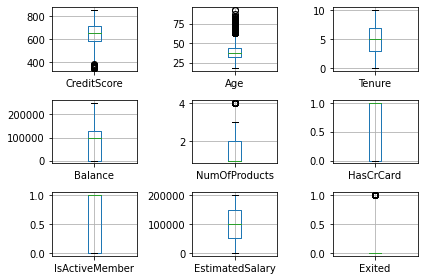

In [9]:
fig, axes = plt.subplots(3,3)
axes = axes.flatten()
for i, feature in enumerate(num_churn.columns):
    num_churn.boxplot(feature,ax=axes[i])
plt.tight_layout() 

Boxplots for CreditScore, Age, and NumOfProducts reveal outliers. There seems to be only one for the feature NumOfProducts, and several for the other two.  By default, outliers extend no more than 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box, ending at the farthest data point within that interval. We can get more information on these. 

There are 15 outliers below the value 383.0 for feature CreditScore
There are 359 outliers above the value 62.0 for feature Age
There are 60 outliers above the value 3.0 for feature NumOfProducts


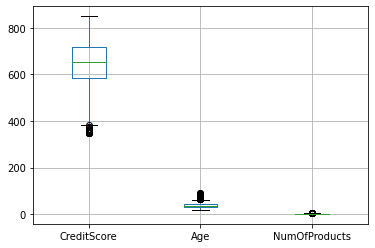

In [10]:
outlr_ftrs = {'CreditScore':'below','Age':'above','NumOfProducts':'above'}
ftrs = list(outlr_ftrs.keys())
_, bp_lns = num_churn.boxplot(column = ftrs,return_type='both')
nb_outlrs = [len(flier.get_ydata()) for flier in bp_lns["fliers"]]

whiskers = [whiskers.get_ydata() for whiskers in bp_lns["whiskers"]]
outlr_whiskers = [whiskers[0][1],whiskers[3][1],whiskers[5][1]]
outlr_data = zip(ftrs,nb_outlrs,outlr_whiskers)
for tup in outlr_data:
    print('There are {} outliers {} the value {} for feature {}'.format(tup[1],outlr_ftrs[tup[0]],tup[2],tup[0]))


How to handle outliers is a problem dependant question. We restrict ourselves to provide quantitative information on them. Moving on, we group our dataset according to different values for some features. Our goal is to see the influence of these on customer churn. 

In [11]:
actv_ctry_gp = churn_df.groupby(['IsActiveMember']).sum()
print(actv_ctry_gp[['Exited']])
actv_ctry_gp = churn_df.groupby(['Geography']).sum()
print(actv_ctry_gp[['Exited']])
ctry_gndr_gp = churn_df.groupby(['Gender']).sum()
print(ctry_gndr_gp[['Exited']])
nb_prdt = churn_df.groupby('NumOfProducts').sum()
print(nb_prdt[['Exited']])

                Exited
IsActiveMember        
0                 1302
1                  735
           Exited
Geography        
France        810
Germany       814
Spain         413
        Exited
Gender        
Female    1139
Male       898
               Exited
NumOfProducts        
1                1409
2                 348
3                 220
4                  60


We appreciate that:
- Among the customers who churned, the number of non-active is close to 2 times the number of those who were active. This remark holds true for individual countries as well.
- The number of clients leaving Telco is similar in France and Germany. Spain present a less important churn, close to half the number in the other two countries.  
- There is 26% more women churning than men.
- Churn decreases as number of products increases, with close to 70% of churning clients holding only one product.

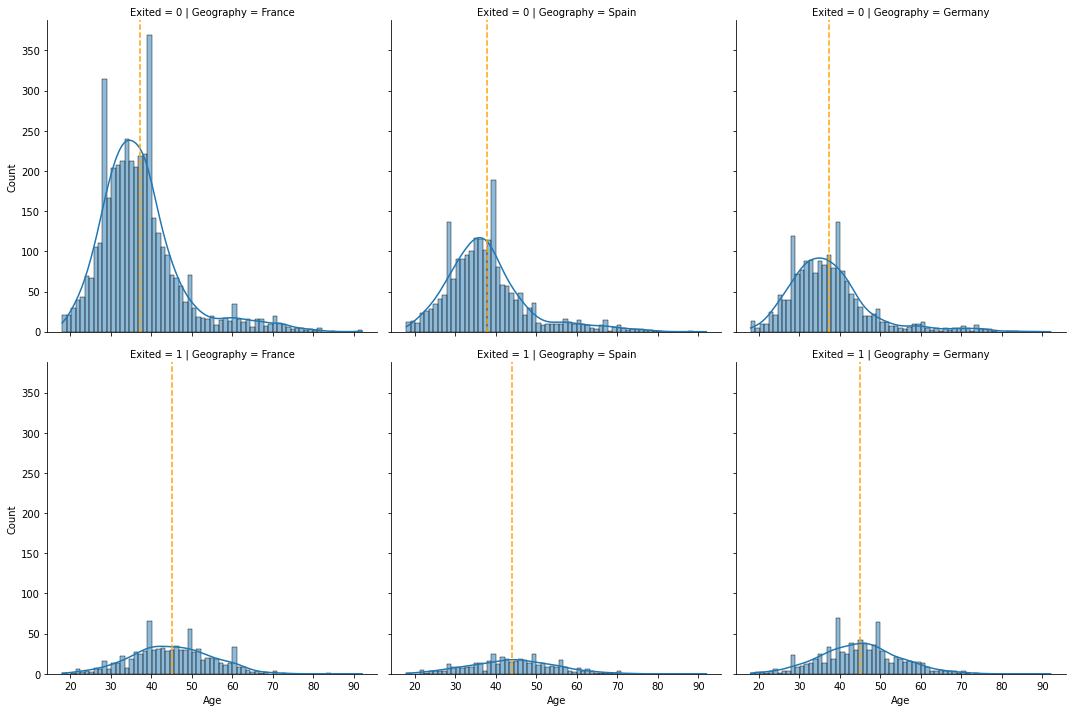

In [12]:
def specs(feature, **kwargs):
    plt.axvline(feature.mean(), c='orange', ls='--')
    plt.title('by country and churn status')
age_grid = sns.displot(churn_df,x='Age',col='Geography',row='Exited',kde=True)
age_grid.map(specs,'Age')

Plotting histograms for Age distribution, we see that in every country the distribution of the clients who did not churn is right skewed. For each country the most frequent age (i.e. the mean, represented by the vertical dashed line) for these people is between 37 and 38. On the other side, churning clients seem to have ages falling into a normal distribution. We pay a close look at these.

In [13]:
mask = num_churn.Exited == 1 
exited_df = num_churn.loc[mask]
stats_df = exited_df.describe()
stats_df = stats_df.rename(index={'25%':'Q1','50%':'median','75%':'Q3'})
stats_df = stats_df.transpose()
stats_df.loc[['Age']]

,count,mean,std,min,Q1,median,Q3,max
Age,2037.0,44.837997,9.761562,18.0,38.0,45.0,51.0,84.0


A key observation drawn from the data displayed above is that $\textbf{66% of the exiting clients have ages in between 35 and 54}$. Indeed, from basic statistics we know that 2/3 of the population are contained in the interval [$\mu-\sigma$,$\mu+\sigma$], where $\mu$ stand for mean (44.8) and $\sigma$ for standard deviation (9.7). Great attention should be paid to clients in these age range. We can also appreciate this in the following plot where the interval is framed by the two dashed red horizontal lines.

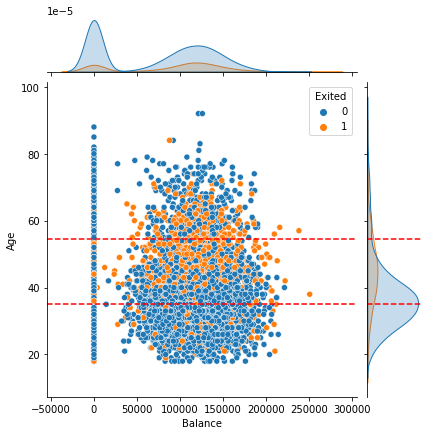

In [18]:
credit_age = sns.jointplot(data=num_churn,x='Balance',y='Age',hue='Exited')
credit_age.refline(y=35.1,color='red')
credit_age.refline(y=54.5,color='red')

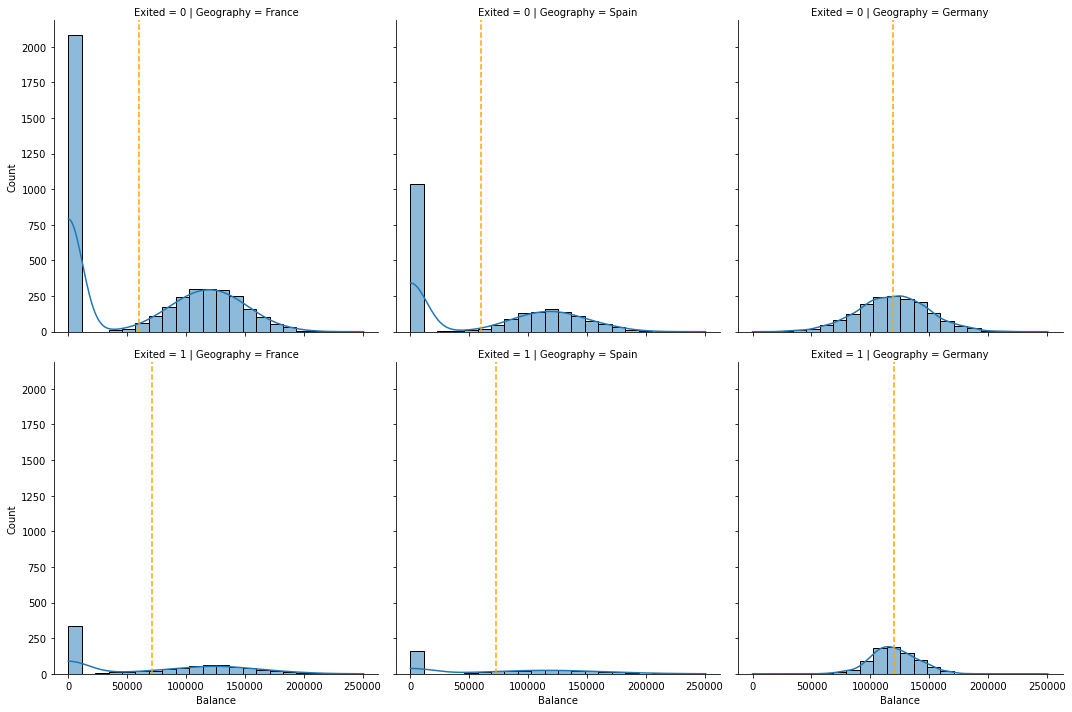

In [15]:
balance_grid = sns.displot(churn_df,x='Balance',col='Geography',row='Exited',kde=True)
balance_grid.map(specs,'Balance')

We see that there an important number of clients with balance equal to 0 (except in Germany). Let's create a binary variable to capture this and see how churn behaves with respect to it.

In [20]:
churn_df['Binary_balance'] = churn_df['Balance'].where(churn_df['Balance'] == 0, 1) #create new feature
bin_bal_ctry_gp = churn_df.groupby(['Binary_balance']).agg(['sum','mean'])
bin_bal_ctry_gp[['Exited']]

Exited          
                  sum      mean
Binary_balance                 
0.0               500  0.138236
1.0              1537  0.240796

From the table above we see that, among churning clients, there is around 3 times more having balance different from zero (balance_binary = 1) than those having zero balance. Also,
- Among clients having balance zero, the percentage of those who churn is 13%.  
- Among customers with balance different from zero, the churn/~churn ratio is 24%.

In [ ]:
salary_grid = sns.displot(churn_df,x='EstimatedSalary',col='Geography',row='Exited',kde=True)
salary_grid.map(specs,'EstimatedSalary')
plt.tight_layout()

The Salary feature seems to have a uniform distribution. We finalize our analysis displaying a correlation matrix.

<AxesSubplot:>

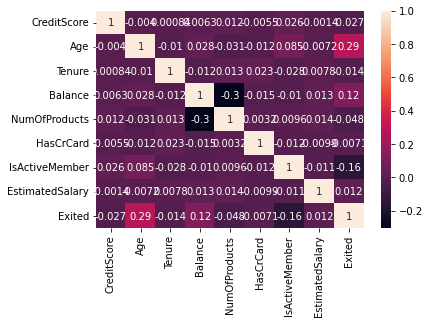

In [21]:
corr_matrix = num_churn.corr()
sns.heatmap(corr_matrix, annot=True)

We observe a positive correlation between Churn and Age (0.29), Churn and Balance (0.12), and a negative correlation between Churn and IsActiveMember (-0.16). The second of these agrees with the fact that, as previously stated, clients with positive balance are more likely to churn than those with zero balance. The third value obtain is also plausible, since as expressed above, active members are less likely to churn.